# Find the fingerprints of ENSO and the IPO in observed gridded datasets

Purpose
-------

    1.    Decompose the temperature time series into Intrinsic Mode Functions (IMFs) using EMD.
            i)  remove monthly climatology
            ii) remove linear trend over timeseries
    2.    Identify and correlate relevant IMFs with known indices for ENSO and IPO.
    3.    Compute slope of relationship between ENSO/IPO and variable of interest to quantify effect of ENSO/IPO


### IMPORTS

In [46]:

import sys
import os
import glob

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
import cmocean.cm as cmo
from cmocean.tools import lighten
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# oceanographic
import gsw as gsw

# statistics
import scipy as sci
from scipy.signal import hilbert
from PyEMD import EMD

# regridding package
import xesmf as xe

# Copernicus marine toolbox
#import copernicusmarine
#from pprint import pprint
#copernicusmarine.login()

# print versions of packages
print("python version =",sys.version[:5])
print("numpy version =", np.__version__)
print("pandas version =", pd.__version__)
print("scipy version =", sci.__version__)
print("xarray version =", xr.__version__)
print("xesmf version =", xe.__version__)
print("cartopy version =", sys.modules[ccrs.__package__].__version__)
print("matplotlib version =", sys.modules[plt.__package__].__version__)
print("cmocean version =", sys.modules[cmo.__package__].__version__)


wrkdir="/g/data/es60/pjb581/SPC"
os.chdir(wrkdir)
os.getcwd()


python version = 3.10.
numpy version = 2.1.3
pandas version = 2.2.3
scipy version = 1.15.1
xarray version = 2024.11.0
xesmf version = 0.8.8
cartopy version = 0.24.1
matplotlib version = 3.10.0
cmocean version = v3.0.3


'/g/data/es60/pjb581/SPC'

## Load the IMFs of the ACCESS-ESM-1.5

In [47]:
%%time

sst_imfs_ds = {}
members = []
for ii in np.arange(1,41,1):
    file_path = "/g/data/es60/pjb581/SPC/data/r%ii1p1f1_sst_imfs.nc"%(ii)
    if os.path.exists(file_path):
        sst_imfs_ds["r%ii1p1f1"%(ii)] = xr.open_dataset(file_path).compute()  # Load the file
        members.append("r%ii1p1f1"%(ii))
        print("Loaded member: r%ii1p1f1"%(ii))


Loaded member: r8i1p1f1
Loaded member: r11i1p1f1
Loaded member: r13i1p1f1
Loaded member: r15i1p1f1
Loaded member: r27i1p1f1
Loaded member: r39i1p1f1
Loaded member: r40i1p1f1
CPU times: user 100 ms, sys: 40 s, total: 40.1 s
Wall time: 1min 34s


## Load the ENSO and IPO from the ACCESS-ESM-1.5 members

CPU times: user 148 ms, sys: 23.7 ms, total: 171 ms
Wall time: 551 ms


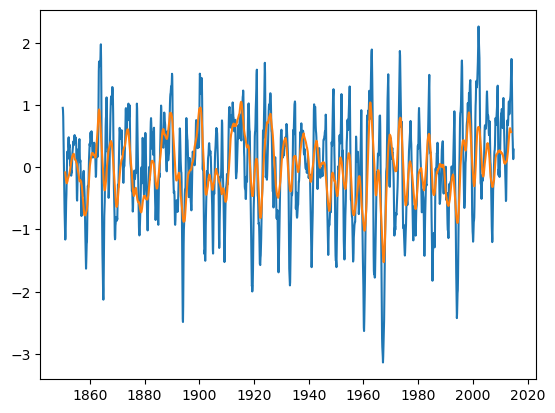

In [48]:
%%time

enso_ds = xr.open_dataset("/g/data/es60/pjb581/SPC/data/ACCESS-ESM1-5_ONI.nc").compute()
ipo_ds = xr.open_dataset("/g/data/es60/pjb581/SPC/data/ACCESS-ESM1-5_TPI.nc").compute()

time = enso_ds.coords['time']

plt.figure()
plt.plot(time, enso_ds['r1i1p1f1'])
plt.plot(time, ipo_ds['r1i1p1f1'])


## Correlation analysis against ENSO and IPO indices

In [49]:
members

['r8i1p1f1',
 'r11i1p1f1',
 'r13i1p1f1',
 'r15i1p1f1',
 'r27i1p1f1',
 'r39i1p1f1',
 'r40i1p1f1']

In [50]:
%%time

# Get the latitude and longitude values
lats = sst_imfs_ds[var].coords['j'].values
lons = sst_imfs_ds[var].coords['i'].values
lons_2d = sst_imfs_ds[var].coords["longitude"].values  # (j, i)
lats_2d = sst_imfs_ds[var].coords["latitude"].values  # (j, i)

enso_tmp = np.zeros((5, 300, 360))
ipo_tmp = np.zeros((5, 300, 360))

for var in members:
    print(f"Doing the stats on member: {var}")
    ### Collect correlations and effects (slopes) of the ENSO and IPO with the variables we care about
    for ix in lons:
        if ix % 40 == 0:
            print(ix)
        for iy in lats:
            data = sst_imfs_ds[var][var+"_sst_imfs"].isel(i=ix, j=iy)
            if data.notnull().all() and not (data == 0.0).all():
                # Get the x and y data
                x1 = enso_ds[var].values
                x2 = ipo_ds[var].values
                y = data.isel(IMF=1).values
                # Create a mask where x is NOT NaN
                maskx1 = ~np.isnan(x1)
                maskx2 = ~np.isnan(x2)
                masky = ~np.isnan(y)
                mask1 = maskx1*masky
                mask2 = maskx2*masky
                # Apply the mask to both x and y
                x1_clean = x1[mask1]
                x2_clean = x2[mask2]
                y1_clean = y[mask1]
                y2_clean = y[mask2]
                enso_tmp[:,iy,ix] = sci.stats.linregress(x1_clean, y1_clean)[:]
                ipo_tmp[:,iy,ix] = sci.stats.linregress(x2_clean, y2_clean)[:]

    # Put into a dataset
    mode_stats = xr.Dataset(
        {
            var+"_sst_enso_stats": (["stats", "j", "i"], enso_tmp),
            var+"_sst_ipo_stats": (["stats", "j", "i"], ipo_tmp),
        },
        coords={
            "stats": np.arange(1,6,1),  # statistics
            "j": lats,
            "i": lons,
            "longitude": (["j", "i"], lons_2d),  # 2D longitude
            "latitude": (["j", "i"], lats_2d)  # 2D latitude
        },
    )
    # Save to disk
    file_path = f"/g/data/es60/pjb581/SPC/data/{var}_sst_mode_statistics.nc"
    if os.path.exists(file_path):
        os.remove(file_path)
    mode_stats.to_netcdf(file_path)

Doing the stats on member: r8i1p1f1
0
40
80
120
160
200
240
280
320
Doing the stats on member: r11i1p1f1
0
40
80
120
160
200
240
280
320
Doing the stats on member: r13i1p1f1
0
40
80
120
160
200
240
280
320
Doing the stats on member: r15i1p1f1
0
40
80
120
160
200
240
280
320
Doing the stats on member: r27i1p1f1
0
40
80
120
160
200
240
280
320
Doing the stats on member: r39i1p1f1
0
40
80
120
160
200
240
280
320
Doing the stats on member: r40i1p1f1
0
40
80
120
160
200
240
280
320
CPU times: user 17min 19s, sys: 921 ms, total: 17min 20s
Wall time: 17min 21s


## Load the above (precooked)

In [58]:
os.chdir(wrkdir + "/data")

enso_sst_ccoef = xr.open_dataset("sst_corr_ENSO_IPO.nc")["sst_corr_enso"]
ipo_sst_ccoef = xr.open_dataset("sst_corr_ENSO_IPO.nc")["sst_corr_ipo"]
enso_sst_effect = xr.open_dataset("sst_effect_ENSO_IPO.nc")["sst_effect_enso"]
ipo_sst_effect = xr.open_dataset("sst_effect_ENSO_IPO.nc")["sst_effect_ipo"]

enso_mld_ccoef = xr.open_dataset("mld_corr_ENSO_IPO.nc")["mld_corr_enso"]
ipo_mld_ccoef = xr.open_dataset("mld_corr_ENSO_IPO.nc")["mld_corr_ipo"]
enso_mld_effect = xr.open_dataset("mld_effect_ENSO_IPO.nc")["mld_effect_enso"]
ipo_mld_effect = xr.open_dataset("mld_effect_ENSO_IPO.nc")["mld_effect_ipo"]

enso_oxy200m_ccoef = xr.open_dataset("oxy200m_corr_ENSO_IPO.nc")["oxy200m_corr_enso"]
ipo_oxy200m_ccoef = xr.open_dataset("oxy200m_corr_ENSO_IPO.nc")["oxy200m_corr_ipo"]
enso_oxy200m_effect = xr.open_dataset("oxy200m_effect_ENSO_IPO.nc")["oxy200m_effect_enso"]
ipo_oxy200m_effect = xr.open_dataset("oxy200m_effect_ENSO_IPO.nc")["oxy200m_effect_ipo"]

enso_oxycline_ccoef = xr.open_dataset("oxycline_corr_ENSO_IPO.nc")["oxycline_corr_enso"]
ipo_oxycline_ccoef = xr.open_dataset("oxycline_corr_ENSO_IPO.nc")["oxycline_corr_ipo"]
enso_oxycline_effect = xr.open_dataset("oxycline_effect_ENSO_IPO.nc")["oxycline_effect_enso"]
ipo_oxycline_effect = xr.open_dataset("oxycline_effect_ENSO_IPO.nc")["oxycline_effect_ipo"]

enso_p50_critz_ccoef = xr.open_dataset("p50_critz_corr_ENSO_IPO.nc")["p50_critz_corr_enso"]
ipo_p50_critz_ccoef = xr.open_dataset("p50_critz_corr_ENSO_IPO.nc")["p50_critz_corr_ipo"]
enso_p50_critz_effect = xr.open_dataset("p50_critz_effect_ENSO_IPO.nc")["p50_critz_effect_enso"]
ipo_p50_critz_effect = xr.open_dataset("p50_critz_effect_ENSO_IPO.nc")["p50_critz_effect_ipo"]

enso_chl_ccoef = xr.open_dataset("chl_corr_ENSO_IPO.nc")["chl_corr_enso"]
ipo_chl_ccoef = xr.open_dataset("chl_corr_ENSO_IPO.nc")["chl_corr_ipo"]
enso_chl_effect = xr.open_dataset("chl_effect_ENSO_IPO.nc")["chl_effect_enso"]
ipo_chl_effect = xr.open_dataset("chl_effect_ENSO_IPO.nc")["chl_effect_ipo"]

enso_p50_critz_ccoef

FileNotFoundError: [Errno 2] No such file or directory: '/g/data/es60/pjb581/SPC/data/chl_corr_ENSO_IPO.nc'

## Visualise the correlations

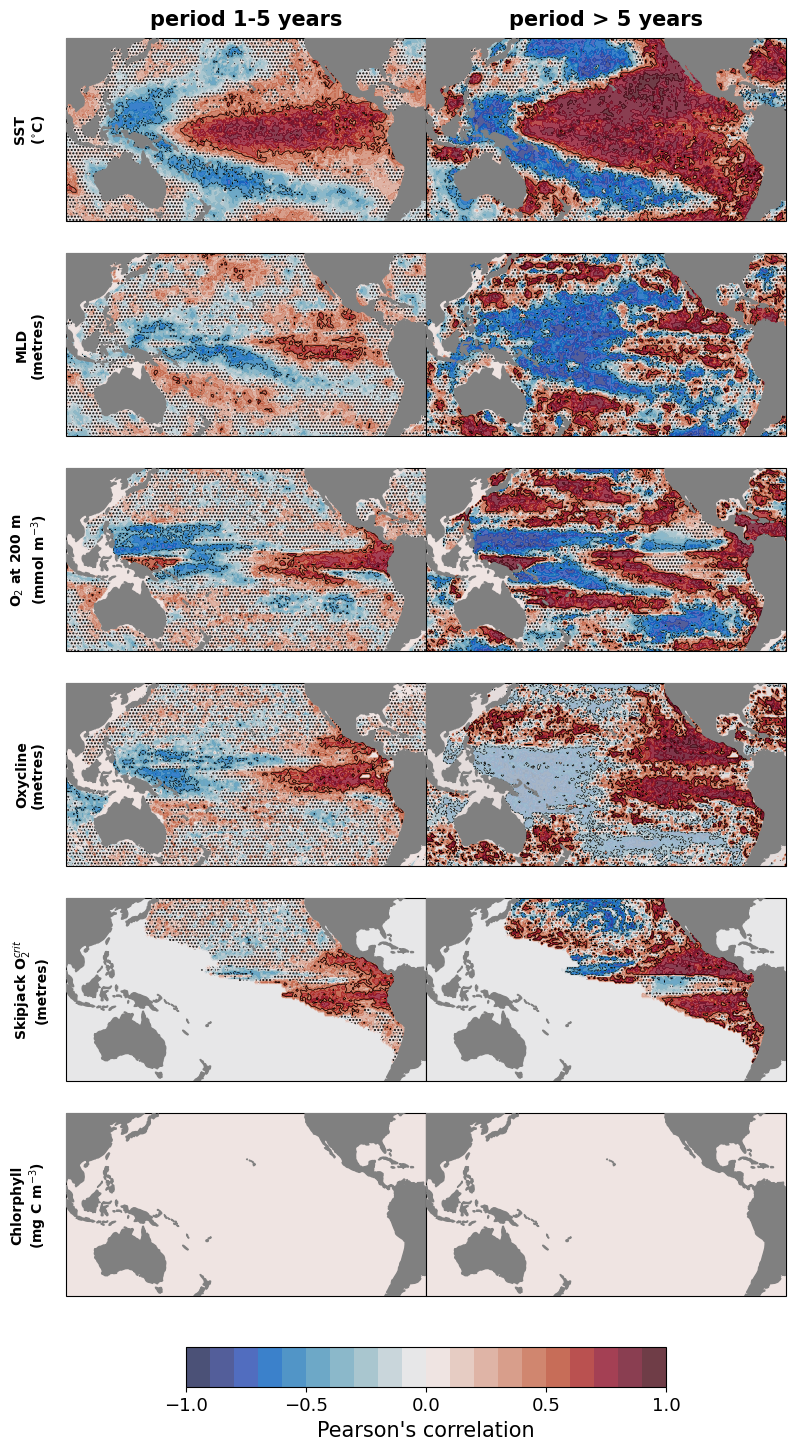

In [56]:

lon_sst = sst_imfs.coords['lon'].values
lat_sst = sst_imfs.coords['lat'].values
lon_oxy = oxy200m_imfs.coords['lon'].values
lat_oxy = oxy200m_imfs.coords['lat'].values
lon_chl = chl_imfs.coords['lon'].values
lat_chl = chl_imfs.coords['lat'].values

fslab = 15
fstic = 13

proj = ccrs.Robinson(central_longitude=205)

colmap = lighten(cmo.balance, 0.8)
levs = np.arange(-1,1.1,0.1)
contlevs = [-0.5, 0.5]
hatching = [' ', '.....']
hatchlevs = [0.0, 0.05, 1.0]

fig = plt.figure(figsize=(8,16))
gs = GridSpec(6, 2)

ax1 = plt.subplot(gs[0,0], projection=proj)
ax2 = plt.subplot(gs[0,1], projection=proj)
ax3 = plt.subplot(gs[1,0], projection=proj)
ax4 = plt.subplot(gs[1,1], projection=proj)
ax5 = plt.subplot(gs[2,0], projection=proj)
ax6 = plt.subplot(gs[2,1], projection=proj)
ax7 = plt.subplot(gs[3,0], projection=proj)
ax8 = plt.subplot(gs[3,1], projection=proj)
ax9 = plt.subplot(gs[4,0], projection=proj)
ax10 = plt.subplot(gs[4,1], projection=proj)
ax11 = plt.subplot(gs[5,0], projection=proj)
ax12 = plt.subplot(gs[5,1], projection=proj)

p1 = ax1.contourf(lon_sst, lat_sst, enso_sst_ccoef[0,:,:]+1e-2, cmap=colmap, levels=levs, extend='neither', transform=ccrs.PlateCarree())
ax1.contour(lon_sst, lat_sst, enso_sst_ccoef[0,:,:], colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())
ax1.contourf(lon_sst, lat_sst, enso_sst_ccoef[1,:,:], colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())

p2 = ax2.contourf(lon_sst, lat_sst, ipo_sst_ccoef[0,:,:]+1e-2, cmap=colmap, levels=levs, extend='neither', transform=ccrs.PlateCarree())
ax2.contour(lon_sst, lat_sst, ipo_sst_ccoef[0,:,:], colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())
ax2.contourf(lon_sst, lat_sst, ipo_sst_ccoef[1,:,:], colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())

p3 = ax3.contourf(lon_sst, lat_sst, enso_mld_ccoef[0,:,:]+1e-2, cmap=colmap, levels=levs, extend='neither', transform=ccrs.PlateCarree())
ax3.contour(lon_sst, lat_sst, enso_mld_ccoef[0,:,:], colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())
ax3.contourf(lon_sst, lat_sst, enso_mld_ccoef[1,:,:], colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())

p4 = ax4.contourf(lon_sst, lat_sst, ipo_mld_ccoef[0,:,:]+1e-2, cmap=colmap, levels=levs, extend='neither', transform=ccrs.PlateCarree())
ax4.contour(lon_sst, lat_sst, ipo_mld_ccoef[0,:,:], colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())
ax4.contourf(lon_sst, lat_sst, ipo_mld_ccoef[1,:,:], colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())

p5 = ax5.contourf(lon_oxy, lat_oxy, enso_oxy200m_ccoef[0,:,:]+1e-2, cmap=colmap, levels=levs, extend='neither', transform=ccrs.PlateCarree())
ax5.contour(lon_oxy, lat_oxy, enso_oxy200m_ccoef[0,:,:], colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())
ax5.contourf(lon_oxy, lat_oxy, enso_oxy200m_ccoef[1,:,:], colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())

p6 = ax6.contourf(lon_oxy, lat_oxy, ipo_oxy200m_ccoef[0,:,:]+1e-2, cmap=colmap, levels=levs, extend='neither', transform=ccrs.PlateCarree())
ax6.contour(lon_oxy, lat_oxy, ipo_oxy200m_ccoef[0,:,:], colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())
ax6.contourf(lon_oxy, lat_oxy, ipo_oxy200m_ccoef[1,:,:], colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())

p7 = ax7.contourf(lon_oxy, lat_oxy, enso_oxycline_ccoef[0,:,:]-1e-2, cmap=colmap, levels=levs, extend='neither', transform=ccrs.PlateCarree())
ax7.contour(lon_oxy, lat_oxy, enso_oxycline_ccoef[0,:,:], colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())
ax7.contourf(lon_oxy, lat_oxy, enso_oxycline_ccoef[1,:,:], colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())

p8 = ax8.contourf(lon_oxy, lat_oxy, ipo_oxycline_ccoef[0,:,:]-1e-2, cmap=colmap, levels=levs, extend='neither', transform=ccrs.PlateCarree())
ax8.contour(lon_oxy, lat_oxy, ipo_oxycline_ccoef[0,:,:], colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())
ax8.contourf(lon_oxy, lat_oxy, ipo_oxycline_ccoef[1,:,:], colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())

p9 = ax9.contourf(lon_oxy, lat_oxy, enso_p50_critz_ccoef[0,:,:]-1e-3, cmap=colmap, levels=levs, extend='neither', transform=ccrs.PlateCarree())
ax9.contour(lon_oxy, lat_oxy, enso_p50_critz_ccoef[0,:,:], colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())
ax9.contourf(lon_oxy, lat_oxy, enso_p50_critz_ccoef[1,:,:], colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())

p10 = ax10.contourf(lon_oxy, lat_oxy, ipo_p50_critz_ccoef[0,:,:]-1e-3, cmap=colmap, levels=levs, extend='neither', transform=ccrs.PlateCarree())
ax10.contour(lon_oxy, lat_oxy, ipo_p50_critz_ccoef[0,:,:], colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())
ax10.contourf(lon_oxy, lat_oxy, ipo_p50_critz_ccoef[1,:,:], colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())

p11 = ax11.contourf(lon_chl, lat_chl, enso_chl_ccoef[0,:,:]+1e-2, cmap=colmap, levels=levs, extend='neither', transform=ccrs.PlateCarree())
ax11.contour(lon_chl, lat_chl, enso_chl_ccoef[0,:,:], colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())
ax11.contourf(lon_chl, lat_chl, enso_chl_ccoef[1,:,:], colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())

p12 = ax12.contourf(lon_chl, lat_chl, ipo_chl_ccoef[0,:,:]+1e-2, cmap=colmap, levels=levs, extend='neither', transform=ccrs.PlateCarree())
ax12.contour(lon_chl, lat_chl, ipo_chl_ccoef[0,:,:], colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())
ax12.contourf(lon_chl, lat_chl, ipo_chl_ccoef[1,:,:], colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())

ax1.add_feature(cfeature.LAND, color='grey', zorder=3)
ax2.add_feature(cfeature.LAND, color='grey', zorder=3)
ax3.add_feature(cfeature.LAND, color='grey', zorder=3)
ax4.add_feature(cfeature.LAND, color='grey', zorder=3)
ax5.add_feature(cfeature.LAND, color='grey', zorder=3)
ax6.add_feature(cfeature.LAND, color='grey', zorder=3)
ax7.add_feature(cfeature.LAND, color='grey', zorder=3)
ax8.add_feature(cfeature.LAND, color='grey', zorder=3)
ax9.add_feature(cfeature.LAND, color='grey', zorder=3)
ax10.add_feature(cfeature.LAND, color='grey', zorder=3)
ax11.add_feature(cfeature.LAND, color='grey', zorder=3)
ax12.add_feature(cfeature.LAND, color='grey', zorder=3)

plt.subplots_adjust(top=0.95, right=0.975, left=0.075, wspace=0.0, hspace=0.05, bottom=0.15)

cbax = fig.add_axes([0.225, 0.1, 0.6, 0.025])
cbar = plt.colorbar(p1, cax=cbax, orientation='horizontal', ticks=levs[::5])
cbar.ax.set_xlabel("Pearson's correlation", fontsize=fslab)
cbar.ax.tick_params(labelsize=fstic)

xx = -0.1; yy = 0.5
plt.text(xx, yy, 'SST\n($^{\circ}$C)', ha='center', va='center', fontsize=fstic-3, fontweight='bold', rotation=90, transform=ax1.transAxes)
plt.text(xx, yy, 'MLD\n(metres)', ha='center', va='center', fontsize=fstic-3, fontweight='bold', rotation=90, transform=ax3.transAxes)
plt.text(xx, yy, 'O$_2$ at 200 m\n(mmol m$^{-3}$)', ha='center', va='center', fontsize=fstic-3, fontweight='bold', rotation=90, transform=ax5.transAxes)
plt.text(xx, yy, 'Oxycline\n(metres)', ha='center', va='center', fontsize=fstic-3, fontweight='bold', rotation=90, transform=ax7.transAxes)
plt.text(xx, yy, 'Skipjack O$^{crit}_2$\n(metres)', ha='center', va='center', fontsize=fstic-3, fontweight='bold', rotation=90, transform=ax9.transAxes)
plt.text(xx, yy, 'Chlorphyll\n(mg C m$^{-3}$)', ha='center', va='center', fontsize=fstic-3, fontweight='bold', rotation=90, transform=ax11.transAxes)

ax1.text(0.5, 1.1, 'period 1-5 years', fontsize=fslab, fontweight='bold', ha='center', va='center', transform=ax1.transAxes)
ax2.text(0.5, 1.1, 'period > 5 years', fontsize=fslab, fontweight='bold', ha='center', va='center', transform=ax2.transAxes)

lon1 = 100; lon2 = 300
lat1 = -45; lat2 = 45
ax1.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax2.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax3.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax4.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax5.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax6.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax7.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax8.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax9.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax10.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax11.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax12.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())



In [ ]:
os.chdir(wrkdir)
fig.savefig("./figures/obs_decomposition_correlations_zoompacific.png", dpi=300)
fig.savefig("./figures/obs_decomposition_correlations_zoompacific_transparent.png", dpi=300, transparent=True)
